# Deep Learning - Project

## Parking Space Detection

### Group 02

In [ ]:
# RUN ONLY IN Google Colab
#!pip install ultralytics

# 0. Imports & Global Constants

In [4]:
import os
import random
import shutil
import xml.etree.ElementTree as ET

ORIGINAL_DATASET_PATH = "./datasets/original"
TRANSFORMED_DATASET_PATH = "./datasets/transformed"
TRAINING_DATASET_PATH = "./datasets/training"
VALIDATION_DATASET_PATH = "./datasets/validation"
TESTING_DATASET_PATH = "./datasets/testing"

TRAINING_RATIO = 0.8
VALIDATION_RATIO = 0.15
TESTING_RATIO = 0.05

GITKEEP = ".gitkeep"
DS_STORE = ".DS_Store"

IMAGE_WIDTH = 1280
IMAGE_HEIGHT = 720

CLASS_MAPPING = {"0": 0, "1": 1}

# 1. Data Pipeline

# 1.1. Transforming

First we start by transforming our original dataset

In [ ]:
for root, _, files in os.walk(ORIGINAL_DATASET_PATH):
    for file in files:
        if file == GITKEEP or file == DS_STORE:
            continue
        source = os.path.join(root, file)
        destination = os.path.join(TRANSFORMED_DATASET_PATH, file)
        shutil.move(source, destination)

for dir in os.listdir(ORIGINAL_DATASET_PATH):
    if not os.path.isdir(dir):
        continue
    path = os.path.join(ORIGINAL_DATASET_PATH, dir)
    shutil.rmtree(path)

print("Merge complete!")

## 1.2. Create the Labels

We'll convert the labels from XML to TXT

In [ ]:
xml_files = [
    file for file in os.listdir(TRANSFORMED_DATASET_PATH) if file.endswith(".xml")
]

for xml_file in xml_files:
    xml_path = os.path.join(TRANSFORMED_DATASET_PATH, xml_file)
    tree = ET.parse(xml_path)
    root = tree.getroot()
    txt_filename = os.path.splitext(xml_file)[0] + ".txt"
    txt_path = os.path.join(TRANSFORMED_DATASET_PATH, txt_filename)
    with open(txt_path, "w") as txt_file:
        for space in root.findall("space"):
            occupied = space.get("occupied")
            class_index = CLASS_MAPPING.get(occupied, -1)
            if class_index == -1:
                continue
            rotated_rect = space.find("rotatedRect")
            center = rotated_rect.find("center")
            size = rotated_rect.find("size")
            x = float(center.get("x")) / IMAGE_WIDTH
            y = float(center.get("y")) / IMAGE_HEIGHT
            w = float(size.get("w")) / IMAGE_WIDTH
            h = float(size.get("h")) / IMAGE_HEIGHT
            txt_file.write(f"{class_index} {x} {y} {w} {h}\n")
    os.remove(xml_path)

print("Conversion complete!")

### Remove invalid files

In [ ]:
def is_valid_file(file):
    filename = os.path.splitext(file)[0]
    jpg_filename = filename + ".jpg"
    txt_filename = filename + ".txt"
    jpg_path = os.path.join(TRANSFORMED_DATASET_PATH, jpg_filename)
    txt_path = os.path.join(TRANSFORMED_DATASET_PATH, txt_filename)
    return os.path.isfile(jpg_path) and os.path.isfile(txt_path)


for file in os.listdir(TRANSFORMED_DATASET_PATH):
    if file == GITKEEP or file == DS_STORE:
        continue
    if not is_valid_file(file):
        file_path = os.path.join(TRANSFORMED_DATASET_PATH, file)
        os.remove(file_path)
        print(f"Removed file: {file_path}")

print("Removal complete!")

# Train Test Split

In [ ]:
folders = [TRAINING_DATASET_PATH, VALIDATION_DATASET_PATH, TESTING_DATASET_PATH]
for folder in folders:
    images_path = os.path.join(folder, "images")
    if not os.path.exists(images_path):
        os.makedirs(images_path)
    labels_path = os.path.join(folder, "labels")
    if not os.path.exists(labels_path):
        os.makedirs(labels_path)

print("Folder creation complete!")

In [ ]:
image_files = [
    file for file in os.listdir(TRANSFORMED_DATASET_PATH) if file.endswith(".jpg")
]

num_samples = len(image_files)
num_training = int(TRAINING_RATIO * num_samples)
num_validation = int(VALIDATION_RATIO * num_samples)
num_testing = num_samples - num_training - num_validation

random.shuffle(image_files)

training_files = image_files[:num_training]
validation_files = image_files[num_training : num_training + num_validation]
testing_files = image_files[num_training + num_validation :]

for folder, files in [
    (TRAINING_DATASET_PATH, training_files),
    (VALIDATION_DATASET_PATH, validation_files),
    (TESTING_DATASET_PATH, testing_files),
]:
    for file in files:
        file_label = os.path.splitext(file)[0] + ".txt"

        source_image_path = os.path.join(TRANSFORMED_DATASET_PATH, file)
        destination_image_path = os.path.join(f"{folder}/images", file)
        shutil.move(source_image_path, destination_image_path)

        source_label_path = os.path.join(TRANSFORMED_DATASET_PATH, file_label)
        destination_label_path = os.path.join(f"{folder}/labels", file_label)
        shutil.move(source_label_path, destination_label_path)

print("Splitting complete!")

# 2. Model Loading

In [30]:
from PIL import Image
from ultralytics import YOLO

MODEL_PATH = "./model/best.pt"
DATASET_INFORMATION_PATH = "./datasets/data.yaml"

NUM_EPOCHS = 2
BATCH_SIZE = 32
IMAGE_SIZE = 640
NUM_WORKERS = 8
DEVICE = 0 # "gpu"


In [31]:
model = YOLO(MODEL_PATH)

### 2.1. Fine Tunning

In [ ]:
train_params = {
    "data": DATASET_INFORMATION_PATH,
    "imgsz": IMAGE_SIZE,
    "batch": BATCH_SIZE,
    "epochs": NUM_EPOCHS,
    "name": "train",
    "exist_ok": False,
    "weight_decay": 0.0005, 
    "optimizer": "Adam",  # Use SGD optimizer
    "device": DEVICE,  
    "workers": NUM_WORKERS
}

model.train(**train_params)

### 2.2. Validation

In [52]:
from sklearn.metrics import classification_report, confusion_matrix

test_images = ".\\datasets\\testing\\images\\2012-09-11_15_53_00_jpg.rf.8282544a640a23df05bd245a9210e663.jpg"
true_labels = ".\\datasets\\testing\\labels"
# Predict on your test dataset. Assuming `test_images` is a list of your test image paths
predictions = model.predict(test_images)

for result in predictions:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    result.save(filename='result.jpg') 


image 1/1 c:\Users\joaom\Documents\FCUL\2Semestre\Deep_Learning\Project\DeepLearning-Project\datasets\testing\images\2012-09-11_15_53_00_jpg.rf.8282544a640a23df05bd245a9210e663.jpg: 640x640 37 emptys, 100 occupieds, 188.2ms
Speed: 0.0ms preprocess, 188.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


In [43]:

test_images_directory = "./datasets/testing/images"

image_files = [f for f in os.listdir(test_images_directory) if f.lower().endswith(".jpg")]

random_image_filename = random.choice(image_files)
random_image_path = os.path.join(test_images_directory, random_image_filename)

results = model.predict(random_image_path)

result = results[0]

print(len(result.boxes))


image 1/1 c:\Users\joaom\Documents\FCUL\2Semestre\Deep_Learning\Project\DeepLearning-Project\datasets\testing\images\2012-12-08_10_40_06_jpg.rf.c9b65984edbcb2c4f5293abcdfbaca27.jpg: 640x640 26 emptys, 5 occupieds, 315.9ms
Speed: 24.1ms preprocess, 315.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
31


In [25]:
backup = random_image_path

In [44]:
for box in result.boxes:
	label = result.names[box.cls[0].item()]
	coords = [round(x) for x in box.xyxy[0].tolist()]
	prob = round(box.conf[0].item(), 4)
	print("Object: {}\nCoordinates: {}\nProbability: {}".format(label, coords, prob))

Object: occupied
Coordinates: [352, 409, 425, 522]
Probability: 0.8312
Object: empty
Coordinates: [204, 192, 243, 252]
Probability: 0.8276
Object: occupied
Coordinates: [377, 361, 438, 445]
Probability: 0.8142
Object: occupied
Coordinates: [238, 505, 325, 616]
Probability: 0.8102
Object: empty
Coordinates: [356, 218, 414, 269]
Probability: 0.8069
Object: empty
Coordinates: [229, 162, 267, 222]
Probability: 0.7978
Object: empty
Coordinates: [339, 253, 402, 313]
Probability: 0.7977
Object: empty
Coordinates: [181, 225, 220, 293]
Probability: 0.7965
Object: empty
Coordinates: [426, 176, 477, 238]
Probability: 0.7909
Object: empty
Coordinates: [388, 292, 451, 386]
Probability: 0.7908
Object: empty
Coordinates: [407, 255, 460, 328]
Probability: 0.7889
Object: empty
Coordinates: [182, 153, 217, 205]
Probability: 0.7857
Object: empty
Coordinates: [417, 210, 470, 278]
Probability: 0.7851
Object: occupied
Coordinates: [326, 492, 400, 624]
Probability: 0.784
Object: empty
Coordinates: [127, 216,

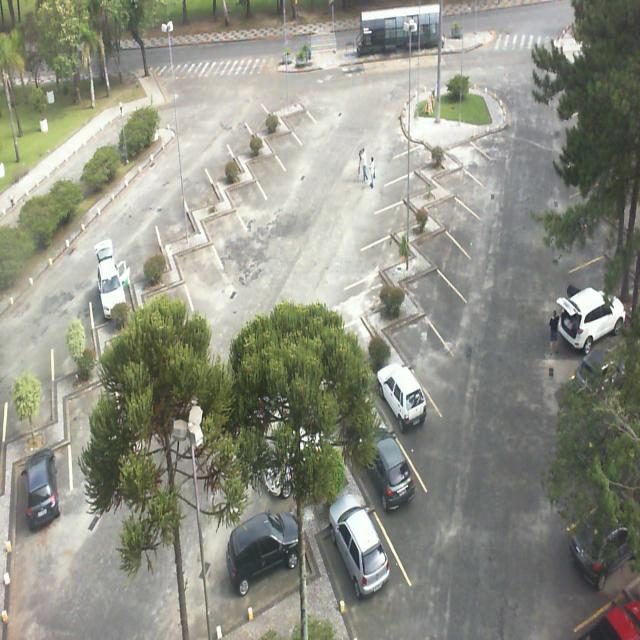

In [45]:
# Original image

Image.open(random_image_path)

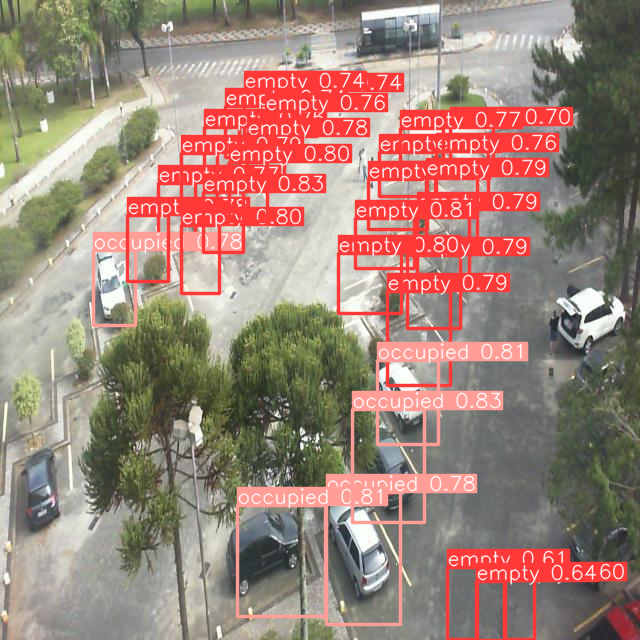

In [46]:
# Image with the result of the model

Image.fromarray(result.plot()[:,:,::-1])